In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Load the two images (both should be in grayscale for SIFT)
pano_img1 = cv2.imread('pano_image1.jpg', cv2.IMREAD_GRAYSCALE)
pano_img2 = cv2.imread('pano_image2.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded properly
if pano_img1 is None or pano_img2 is None:
    raise ValueError("Error: One or both images could not be loaded. Check the file paths.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(pano_img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(pano_img2, None)

# You can visualize keypoints if you want (optional)
# img1_kp = cv2.drawKeypoints(pano_img1, keypoints1, None)
# img2_kp = cv2.drawKeypoints(pano_img2, keypoints2, None)
# cv2.imshow("Keypoints 1", img1_kp)
# cv2.imshow("Keypoints 2", img2_kp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [14]:
#brute force matcher takes every descriptor in img and compares it to every descriptor in the other img and returns the best match
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)#k=2 means it will return the 2 best matches for each descriptor
#y3ni lkol descriptor fe img1 2 matches fe img2
#matches is a list of lists

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if (m.distance/n.distance) < 0.75:
        good_matches.append(m)

#Take the top 50 good matches
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]


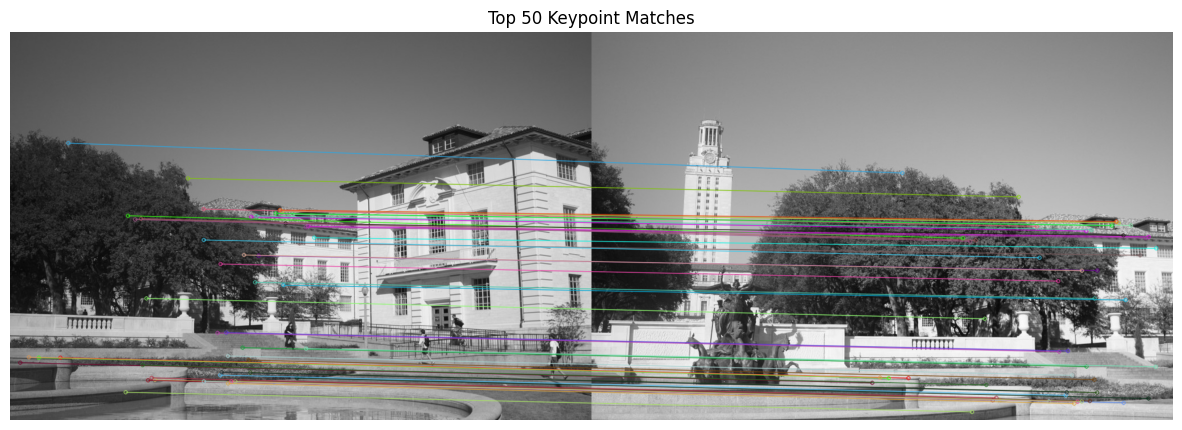

In [15]:
matched_img = cv2.drawMatches(pano_img1, keypoints1, pano_img2, keypoints2, good_matches, None, flags=2)

plt.figure(figsize=(15, 10))
plt.imshow(matched_img, cmap='gray')
plt.title("Top 50 Keypoint Matches")
plt.axis('off')
plt.show()

In [16]:
def compute_homography(src_pts, dst_pts):
    
    #src_pts: List or array of (x, y) points in the first image
    #dst_pts: Corresponding list or array of (x', y') points in the second image

    if len(src_pts) < 4:
        raise ValueError("Need at least 4 point correspondences.")

    A = []
    for (x, y), (x_prime, y_prime) in zip(src_pts, dst_pts):
        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime])

    A = np.array(A)
    b = np.array(dst_pts).reshape(-1)# Flatten the dst_pts array to make it a 1D array
    # print("A shape:", A.shape)
    # print("b shape:", b.shape)
    # Solve Ah = b
    h = np.linalg.lstsq(A, b, rcond=None)[0]# Get the least-squares solution
    #print("Homography coefficients:", h)

    H = np.append(h, 1).reshape((3, 3))#make h33 = 1 and reshape it to 3x3 matrix
    return H


def apply_homography(H, points):
    #Apply the homography matrix to the points.

    points_hom = np.hstack([points, np.ones((len(points), 1))])  # Convert to homogeneous coordinates [x y 1]
    transformed = (H @ points_hom.T).T  # Matrix multiplication to apply the homography

    # Convert back to Cartesian coordinates(2D) by dividing by the last coordinate
    transformed /= transformed[:, 2][:, np.newaxis]
    return transformed[:, :2]## Keep only the x and y coordinates

def draw_projected_points(original_img, projected_pts, actual_pts=None, title="Projected Points"):
    """
    Draws the projected points on the image.

    Args:
        original_img: The image on which to draw (e.g., frame from video).
        projected_pts: Points mapped using the homography.
        actual_pts: Optional ground truth points (to compare).
        title: Title of the plot.
    """
    img_display = original_img.copy()
    if len(img_display.shape) == 2:
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2BGR)

    for pt in projected_pts:
        x, y = int(pt[0]), int(pt[1])
        cv2.circle(img_display, (x, y), 5, (0, 0, 255), -1)  # red dot for projected point

    if actual_pts is not None:
        for pt in actual_pts:
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(img_display, (x, y), 5, (0, 255, 0), 2)  # green circle for actual point

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()